<a href="https://colab.research.google.com/github/bickkysahani/timeseries-forecasting/blob/main/timeseries_forecasting_4_weather_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Weather forecasting LSTM


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Weather_data.csv', parse_dates =['datetime (UTC)'])


Let's take a glance at the data.

In [4]:
df.head()

,datetime (UTC),"coordinates (lat,lon)",model (name),model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
0,2010-01-01 00:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.26,16.39,2.60,101046.38,0.89,287.01,408.35,1.0
1,2010-01-01 01:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.67,16.29,2.91,101037.96,0.86,360.79,411.02,1.0
2,2010-01-01 02:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.16,15.89,3.26,101017.26,0.87,291.54,410.67,1.0
3,2010-01-01 03:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.46,15.33,3.17,101022.56,0.82,357.11,410.95,1.0
4,2010-01-01 04:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.53,15.11,2.95,100940.03,0.80,459.91,410.00,0.9


## The  dataset


This dataset contains 12 different features such as temperature,dewpoint_temperature, wind_speed, surface_solar_radiation,surface_thermal_radiation  and total cloud cover. These were collected every 1 hour, beginning in 2010. 

In [5]:
df.head()

,datetime (UTC),"coordinates (lat,lon)",model (name),model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
0,2010-01-01 00:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.26,16.39,2.60,101046.38,0.89,287.01,408.35,1.0
1,2010-01-01 01:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.67,16.29,2.91,101037.96,0.86,360.79,411.02,1.0
2,2010-01-01 02:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.16,15.89,3.26,101017.26,0.87,291.54,410.67,1.0
3,2010-01-01 03:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.46,15.33,3.17,101022.56,0.82,357.11,410.95,1.0
4,2010-01-01 04:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.53,15.11,2.95,100940.03,0.80,459.91,410.00,0.9


In [6]:
#Lets rename some columns
df = df.rename(columns={'datetime (UTC)':'Date Time',
                                 'coordinates (lat,lon)':'coordinates',
                                  'model (name)':'model',
                                  'model elevation (surface)':'model elevation'
                                  ,'utc_offset (hrs)':'utc',
                                   'temperature (degC)':'Temperature',
                                   'dewpoint_temperature (degC)':'Temperature(dw)',
                                   'wind_speed (m/s)':'Wind Speed',
                                   'mean_sea_level_pressure (Pa)':'Pressure',
                                   'relative_humidity ((0-1))':'Relative Humidity',
                                  'surface_solar_radiation (W/m^2)':'Solar Radiation',
                                  'surface_thermal_radiation (W/m^2)':'Thermal Radiation',
                                  'total_cloud_cover (0-1)':'Total Cloud Cover'
                                  })
#drop some unnecessary columns
df.drop(columns=['coordinates','model','model elevation','utc','Total Cloud Cover'], axis=1, inplace=True)

df['Pressure'] = df['Pressure'].apply(lambda x: x*0.01)

In [7]:
df.head()

,Date Time,Temperature,Temperature(dw),Wind Speed,Pressure,Relative Humidity,Solar Radiation,Thermal Radiation
0,2010-01-01 00:00:00,18.26,16.39,2.60,1010.4638,0.89,287.01,408.35
1,2010-01-01 01:00:00,18.67,16.29,2.91,1010.3796,0.86,360.79,411.02
2,2010-01-01 02:00:00,18.16,15.89,3.26,1010.1726,0.87,291.54,410.67
3,2010-01-01 03:00:00,18.46,15.33,3.17,1010.2256,0.82,357.11,410.95
4,2010-01-01 04:00:00,18.53,15.11,2.95,1009.4003,0.80,459.91,410.00


Lets visualize the data

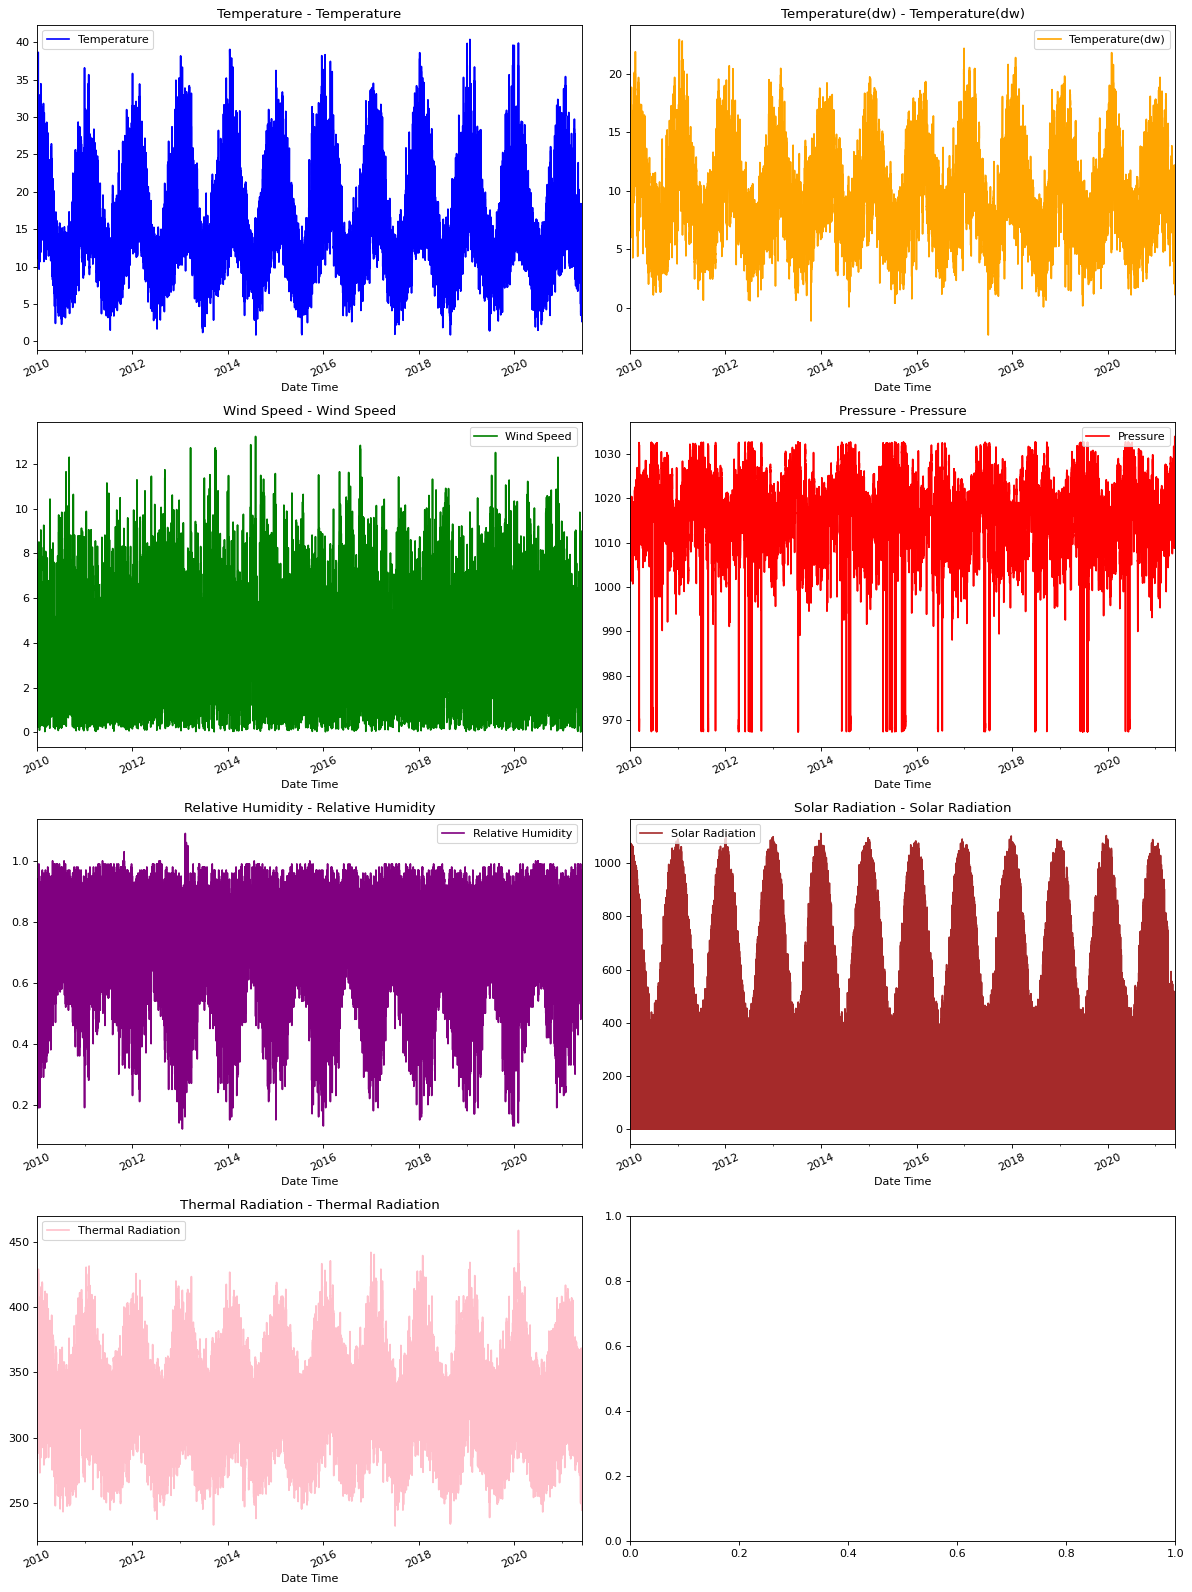

In [8]:
titles = [
    "Temperature",
    "Temperature(dw)",
    "Wind Speed",
    "Pressure",
    "Relative Humidity",
    "Solar Radiation",
    "Thermal Radiation",
    
]

feature_keys = [
   "Temperature",
    "Temperature(dw)",
    "Wind Speed",
    "Pressure",
    "Relative Humidity",
    "Solar Radiation",
    "Thermal Radiation",
    
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=4, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)


This heat map shows the correlation between different features.

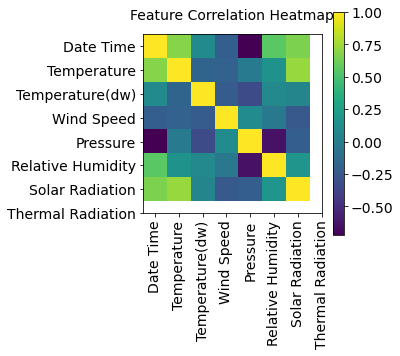

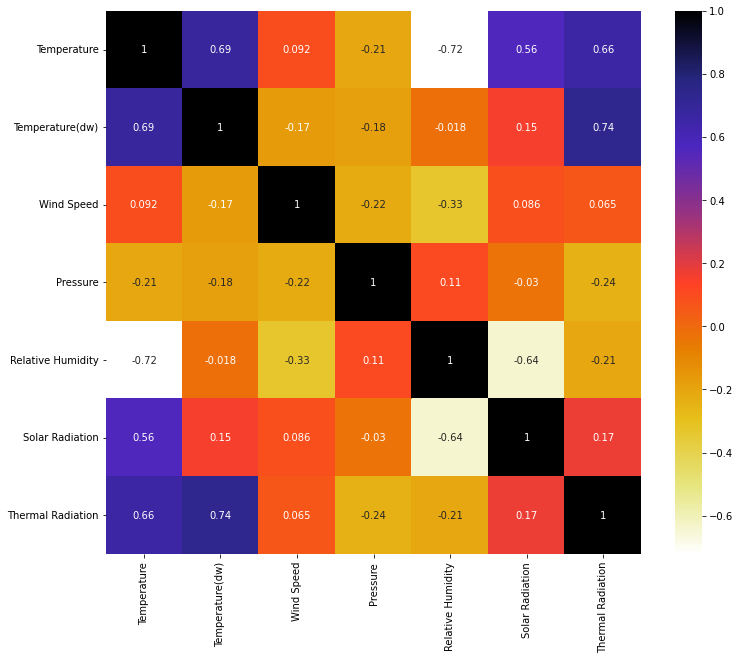

In [9]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    
    plt.title("Feature Correlation Heatmap", fontsize=14)
    import seaborn as sns
  #Using Pearson Correlation
    plt.figure(figsize=(12,10))
    cor =df.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
    plt.show()


show_heatmap(df)

In [10]:
for i,v in enumerate(titles):
    print(i,v)

0 Temperature
1 Temperature(dw)
2 Wind Speed
3 Pressure
4 Relative Humidity
5 Solar Radiation
6 Thermal Radiation


In [11]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 1

past = 72
future = 24
learning_rate = 0.001
batch_size = 256
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [12]:
print("The selected parameters are:",", ".join([titles[i] for i in [0, 1, 2, 3, 4, 5 ,6]]))
      
selected_features = [feature_keys[i] for i in [0, 1, 2, 3, 4, 5 ,6]]
features =df[selected_features]
features.head()
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()
features.shape
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]


The selected parameters are: Temperature, Temperature(dw), Wind Speed, Pressure, Relative Humidity, Solar Radiation, Thermal Radiation


In [13]:
features.head(), features.shape

(          0         1         2         3         4         5         6
 0  0.602596  1.868083 -0.628144 -0.572659  1.010458  0.383764  2.522450
 1  0.675556  1.840567 -0.476359 -0.581543  0.820541  0.659915  2.603226
 2  0.584800  1.730503 -0.304989 -0.603384  0.883847  0.400719  2.592638
 3  0.638186  1.576414 -0.349055 -0.597792  0.567319  0.646142  2.601109
 4  0.650643  1.515879 -0.456774 -0.684870  0.440708  1.030913  2.572368,
 (100057, 7))

In [14]:
train_data.shape, val_data.shape

((71540, 7), (28517, 7))

In [15]:
start = past + future
end = start + train_split

#splitting features and target label
x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)
x_train.shape, y_train.shape

((71540, 7), (71540, 1))

In [16]:
x_train[:5]

array([[ 0.60259563,  1.86808295, -0.62814379, -0.57265943,  1.01045815,
         0.38376354,  2.52244951],
       [ 0.67555625,  1.84056705, -0.47635885, -0.58154341,  0.82054131,
         0.65991545,  2.60322629],
       [ 0.58480035,  1.73050348, -0.30498875, -0.60338406,  0.88384692,
         0.40071892,  2.59263757],
       [ 0.63818617,  1.57641446, -0.34905534, -0.59779201,  0.56731884,
         0.64614154,  2.60110855],
       [ 0.65064286,  1.5158795 , -0.45677369, -0.68486975,  0.44070761,
         1.03091272,  2.57236774]])

In [17]:
y_train[:5]

,1
96,1.474606
97,1.477357
98,1.386555
99,1.204950
100,1.152670


In [18]:
from tensorflow import keras
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [19]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 72, 7)
Target shape: (256, 1)


In [20]:
display(dataset_train)

<BatchDataset shapes: ((None, None, 7), (None, 1)), types: (tf.float64, tf.float64)>

In [21]:
# def univariate_data(dataset, start_index, end_index, history_size, target_size):
#   data = []
#   labels = []

#   start_index = start_index + history_size
#   if end_index is None:
#     end_index = len(dataset) - target_size

#   for i in range(start_index, end_index):
#     indices = range(i-history_size, i)
#     # Reshape data from (history_size,) to (history_size, 1)
#     data.append(np.reshape(dataset[indices], (history_size, 1)))
#     labels.append(dataset[i+target_size])
#   return np.array(data), np.array(labels)

In [22]:
#TRAIN_SPLIT = 300000

Setting seed to ensure reproducibility.

In [23]:
# tf.random.set_seed(13)

In [24]:
# uni_data = df['T (degC)']
# uni_data.index = df['Date Time']
# uni_data.head()

In [25]:
# uni_data.plot(subplots=True)

In [26]:
# uni_data = uni_data.values

In [27]:
# uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
# uni_train_std = uni_data[:TRAIN_SPLIT].std()

Let's normalize the data.

In [28]:
# uni_data = (uni_data-uni_train_mean)/uni_train_std

Let's now create the data for the univariate model. For part 1, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step. 

In [29]:
# univariate_past_history = 20
# univariate_future_target = 0

# x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
#                                            univariate_past_history,
#                                            univariate_future_target)
# x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
#                                        univariate_past_history,
#                                        univariate_future_target)

This is what the `univariate_data` function returns.

In [30]:
# print ('Single window of past history')
# print (x_train_uni[0])
# print ('\n Target temperature to predict')
# print (y_train_uni[0])

Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [31]:
# def create_time_steps(length):
#   time_steps = []
#   for i in range(-length, 0, 1):
#     time_steps.append(i)
#   return time_steps

In [32]:
# def show_plot(plot_data, delta, title):
#   labels = ['History', 'True Future', 'Model Prediction']
#   marker = ['.-', 'rx', 'go']
#   time_steps = create_time_steps(plot_data[0].shape[0])
#   if delta:
#     future = delta
#   else:
#     future = 0

#   plt.title(title)
#   for i, x in enumerate(plot_data):
#     if i:
#       plt.plot(future, plot_data[i], marker[i], markersize=10,
#                label=labels[i])
#     else:
#       plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
#   plt.legend()
#   plt.xlim([time_steps[0], (future+5)*2])
#   plt.xlabel('Time-Step')
#   return plt

In [33]:
# show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [34]:
# def baseline(history):
#   return np.mean(history)

In [35]:
# show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
#            'Baseline Prediction Example')

Let's see if you can beat this baseline using a recurrent neural network.

In [36]:
# BATCH_SIZE = 256
# BUFFER_SIZE = 10000

# train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
# train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
# val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. 

Let's now use `tf.data` to shuffle, batch, and cache the dataset.

In [37]:
# simple_lstm_model = tf.keras.models.Sequential([
#     tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
#     tf.keras.layers.Dense(1)
# ])

# simple_lstm_model.compile(optimizer='adam', loss='mae')

Let's make a sample prediction, to check the output of the model. 

In [38]:
# for x, y in val_univariate.take(1):
#     print(simple_lstm_model.predict(x).shape)

Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 200 steps, instead of the complete training data as normally done.

In [39]:
# EVALUATION_INTERVAL = 200
# EPOCHS = 5

# simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
#                       steps_per_epoch=EVALUATION_INTERVAL,
#                       validation_data=val_univariate, validation_steps=50)

#### Predict using the simple LSTM model
Now that you have trained your simple LSTM, let's try and make a few predictions.

In [40]:
# for x, y in val_univariate.take(3):
#   plot = show_plot([x[0].numpy(), y[0].numpy(),
#                     simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
#   plot.show()

This looks better than the baseline. Now that you have seen the basics, let's move on to part two, where you will work with a multivariate time series.

## Part 2: Forecast a multivariate time series

The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density. 

To use more features, add their names to this list.

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100057 entries, 0 to 100056
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Date Time          100057 non-null  datetime64[ns]
 1   Temperature        100057 non-null  float64       
 2   Temperature(dw)    100057 non-null  float64       
 3   Wind Speed         100057 non-null  float64       
 4   Pressure           100057 non-null  float64       
 5   Relative Humidity  100057 non-null  float64       
 6   Solar Radiation    100057 non-null  float64       
 7   Thermal Radiation  100057 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 6.1 MB


In [42]:
features_considered = ['Temperature','Temperature(dw)', 'Wind Speed', 'Pressure','Relative Humidity','Solar Radiation','Thermal Radiation']

In [43]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,Temperature,Temperature(dw),Wind Speed,Pressure,Relative Humidity,Solar Radiation,Thermal Radiation
Date Time,,,,,,,
2010-01-01 00:00:00,18.26,16.39,2.60,1010.4638,0.89,287.01,408.35
2010-01-01 01:00:00,18.67,16.29,2.91,1010.3796,0.86,360.79,411.02
2010-01-01 02:00:00,18.16,15.89,3.26,1010.1726,0.87,291.54,410.67
2010-01-01 03:00:00,18.46,15.33,3.17,1010.2256,0.82,357.11,410.95
2010-01-01 04:00:00,18.53,15.11,2.95,1009.4003,0.80,459.91,410.00


Let's have a look at how each of these features vary across time.

In [76]:
#features.plot(subplots=True)

As mentioned, the first step will be to normalize the dataset using the mean and standard deviation of the training data.

In [45]:
dataset = features.values
# data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
# data_std = dataset[:TRAIN_SPLIT].std(axis=0)
data_mean = dataset[:train_split].mean(axis=0)
data_std = dataset[:train_split].std(axis=0)

In [46]:
dataset = (dataset-data_mean)/data_std

In [47]:
dataset[:5]

array([[ 0.60259563,  1.86808295, -0.62814379, -0.57265943,  1.01045815,
         0.38376354,  2.52244951],
       [ 0.67555625,  1.84056705, -0.47635885, -0.58154341,  0.82054131,
         0.65991545,  2.60322629],
       [ 0.58480035,  1.73050348, -0.30498875, -0.60338406,  0.88384692,
         0.40071892,  2.59263757],
       [ 0.63818617,  1.57641446, -0.34905534, -0.59779201,  0.56731884,
         0.64614154,  2.60110855],
       [ 0.65064286,  1.5158795 , -0.45677369, -0.68486975,  0.44070761,
         1.03091272,  2.57236774]])

### Single step model
In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the same windowing task as below, however, here it samples the past observation based on the step size given.

In [48]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [49]:
past_history = 72
future_target = 24
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   train_split, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               train_split, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [50]:
x_train_single.shape, y_train_single.shape,x_val_single.shape, y_val_single.shape

((71468, 72, 7), (71468,), (28421, 72, 7), (28421,))

In [51]:
# x_train_single[-2:]

The network is shown data from the last three (3) days, i.e. 72 observations that are sampled every hour. The sampling is done every one hour since a drastic change is not expected within 60 minutes. Thus, 72 observation represent history of the last three days.  For the single step prediction model, the label for a datapoint is the temperature 24 hours into the future. In order to create a label for this, the temperature after 72(12*6) observations is used.

Let's look at a single data-point.


In [52]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (72, 7)


In [53]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [54]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Let's check out a sample prediction.

In [55]:
EVALUATION_INTERVAL = 200
EPOCHS = 10
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 7s 21ms/step - loss: 0.5091 - val_loss: 0.5133
Epoch 2/10
200/200 [==============================] - 4s 18ms/step - loss: 0.4771 - val_loss: 0.4980
Epoch 3/10
200/200 [==============================] - 4s 18ms/step - loss: 0.4701 - val_loss: 0.4987
Epoch 4/10
200/200 [==============================] - 4s 18ms/step - loss: 0.4599 - val_loss: 0.4894
Epoch 5/10
200/200 [==============================] - 4s 18ms/step - loss: 0.4543 - val_loss: 0.4908
Epoch 6/10
200/200 [==============================] - 4s 19ms/step - loss: 0.4534 - val_loss: 0.4763
Epoch 7/10
200/200 [==============================] - 4s 18ms/step - loss: 0.4434 - val_loss: 0.4827
Epoch 8/10
200/200 [==============================] - 4s 18ms/step - loss: 0.4457 - val_loss: 0.4909
Epoch 9/10
200/200 [==============================] - 4s 20ms/step - loss: 0.4383 - val_loss: 0.4923
Epoch 10/10
200/200 [==============================] - 4s 18ms/step - loss: 0.4372 - val_lo

In [56]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [57]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

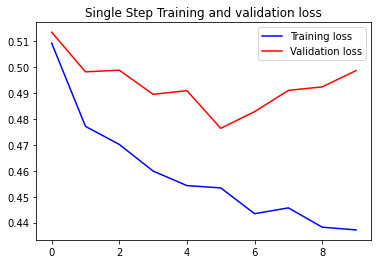

In [58]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step future
Now that the model is trained, let's make a few sample predictions. The model is given the history of three features over the past five days sampled every hour (120 data-points), since the goal is to predict the temperature, the plot only displays the past temperature. The prediction is made one day into the future (hence the gap between the history and prediction). 

In [59]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [60]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

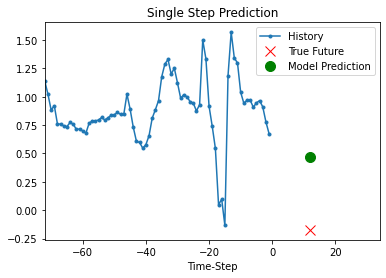

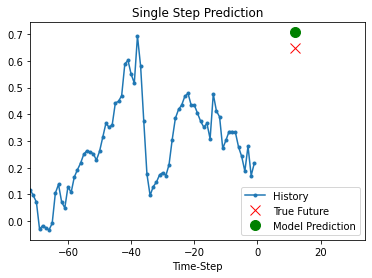

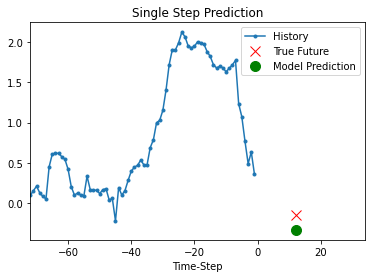

In [61]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [62]:
dataset[:, 0]

array([ 0.60259563,  0.67555625,  0.58480035, ..., -1.09507341,
       -0.89754588, -0.73738843])

In [63]:
future_target = 24
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 0], 0,
                                                 train_split, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 0],
                                             train_split, None, past_history,
                                             future_target, STEP)

Let's check out a sample data-point.

In [64]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

# x_train_multi[:2]

Single window of past history : (72, 7)

 Target temperature to predict : (24,)


In [65]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [66]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.xlabel('Timestamp')
  plt.ylabel('Temperature')
  plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

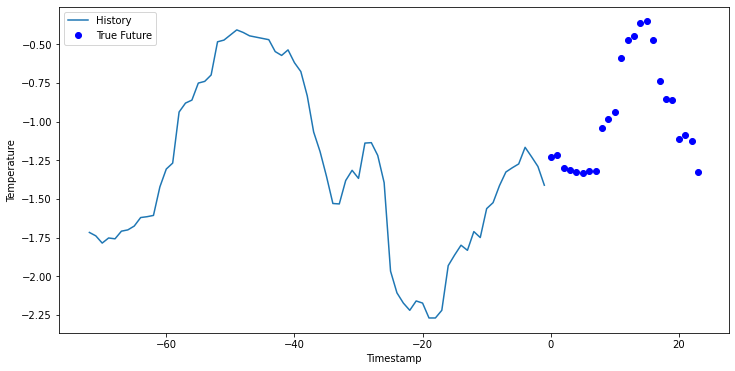

In [67]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

In [68]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(24))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's see how the model predicts before it trains.

In [69]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 24)


In [70]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 52s 242ms/step - loss: 0.5509 - val_loss: 0.4510
Epoch 2/10
200/200 [==============================] - 48s 240ms/step - loss: 0.3671 - val_loss: 0.3321
Epoch 3/10
200/200 [==============================] - 48s 240ms/step - loss: 0.3115 - val_loss: 0.3056
Epoch 4/10
200/200 [==============================] - 49s 245ms/step - loss: 0.2948 - val_loss: 0.2914
Epoch 5/10
200/200 [==============================] - 48s 242ms/step - loss: 0.2822 - val_loss: 0.2898
Epoch 6/10
200/200 [==============================] - 47s 236ms/step - loss: 0.2757 - val_loss: 0.2777
Epoch 7/10
200/200 [==============================] - 48s 238ms/step - loss: 0.2712 - val_loss: 0.2736
Epoch 8/10
200/200 [==============================] - 48s 239ms/step - loss: 0.2672 - val_loss: 0.2665
Epoch 9/10
200/200 [==============================] - 48s 240ms/step - loss: 0.2623 - val_loss: 0.2679
Epoch 10/10
200/200 [==============================] - 48s 241ms/step - l

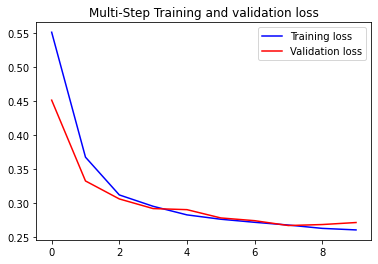

In [71]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

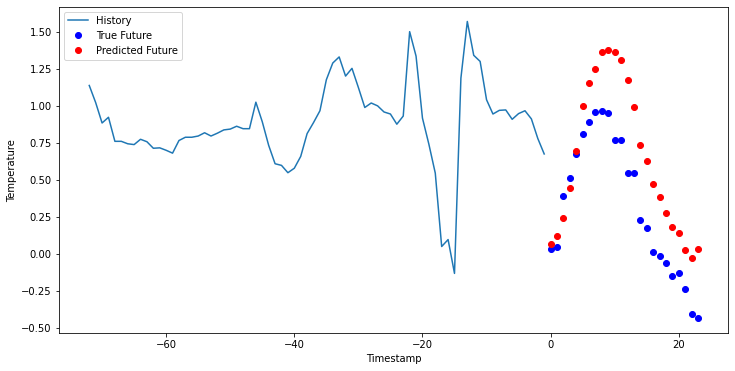

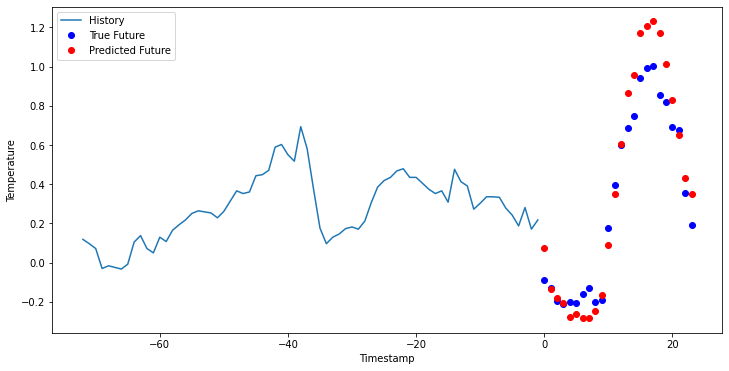

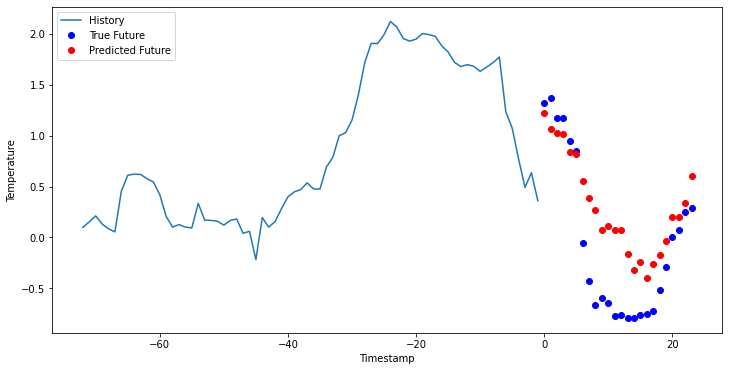

In [72]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])
  

In [73]:
df1 = pd.DataFrame(multi_step_model.predict(x)[0],columns=['Predicted temp'] )

In [74]:
df1.head()

,Predicted temp
0,1.225254
1,1.065540
2,1.022005
3,1.015685
4,0.843764


In [75]:
val_data_multi

<RepeatDataset shapes: ((None, 72, 7), (None, 24)), types: (tf.float64, tf.float64)>